In [1]:
import math
import numpy as np
import cv2

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from calibration_mask import *
from laneFinder import LaneFinder

%load_ext autoreload
%autoreload 2

%matplotlib inline

### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [18]:
# ------------------------------------
plt.rcParams['figure.figsize'] = (20, 15)

sizeBoardCorners = (9, 6)
ret, mtx, dist = calDistortMatrix('camera_cal', sizeBoardCorners, False)

failled finding board from:  camera_cal/calibration5.jpg
failled finding board from:  camera_cal/calibration4.jpg
failled finding board from:  camera_cal/calibration1.jpg


### Apply the distortion correction to one of the calibration image:

In [19]:
# fn = 'camera_cal/calibration2.jpg'
# img = cv2.imread(fn)
# img_corrected = cv2.undistort(img, mtx, dist, None, mtx)

# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# ax1.imshow(img)
# ax1.set_title('Original Image', fontsize=30)
# ax2.imshow(img_corrected)
# ax2.set_title('Undistorted Image', fontsize=30)

### Use color transforms, gradients, etc., to create a thresholded binary image
Define all kinds of masking functions first.

Test the masking over testing images

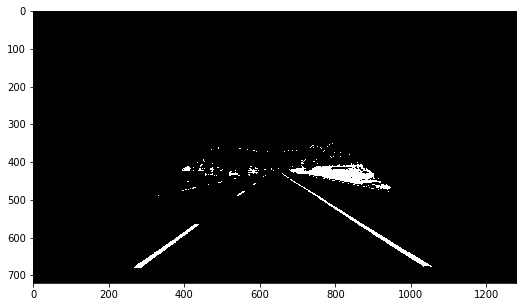

In [21]:
# ------------------------------------
testFn = 'test_images/straight_lines2.jpg'
imgTest = cv2.imread(testFn)

# get all individual masks for check
am = findAllMasks(imgTest)

rg_mask = am['rg']
gradient_mask = am['grad']
s_mask = am['s']
roi_mask = am['roi']

# the final combined mask
combinedMask = combineMasks(imgTest)

# Display
# f, axhandles = plt.subplots(2, 3, figsize=(20,10))

# axhandles[0, 0].imshow(rg_mask*255, cmap='gray')
# axhandles[0, 0].set_title('RG-channel (Yellow) Mask')
# axhandles[0, 1].imshow(gradient_mask*255, cmap='gray')
# axhandles[0, 1].set_title('Gradient Mask')
# axhandles[0, 2].imshow(s_mask*255, cmap='gray')
# axhandles[0, 2].set_title('S-channel (Yellow) Mask')
    
# axhandles[1, 0].imshow(cv2.cvtColor(imgTest, cv2.COLOR_BGR2RGB))
# axhandles[1, 0].set_title('Original Image')
# axhandles[1, 1].imshow(mergeMasks2RGB([rg_mask, gradient_mask, s_mask]))
# axhandles[1, 1].set_title('3 mask in RGB')
# axhandles[1, 2].imshow(combinedMask, cmap='gray')
# axhandles[1, 2].set_title('Combined Mask')

plt.rcParams['figure.figsize'] = (10, 5)
plt.imshow(combinedMask, cmap='gray')

plt.show()

### Apply a perspective transform to rectify binary image ("birds-eye view").

Text(0.5,1,' Bird-view Combined Mask')

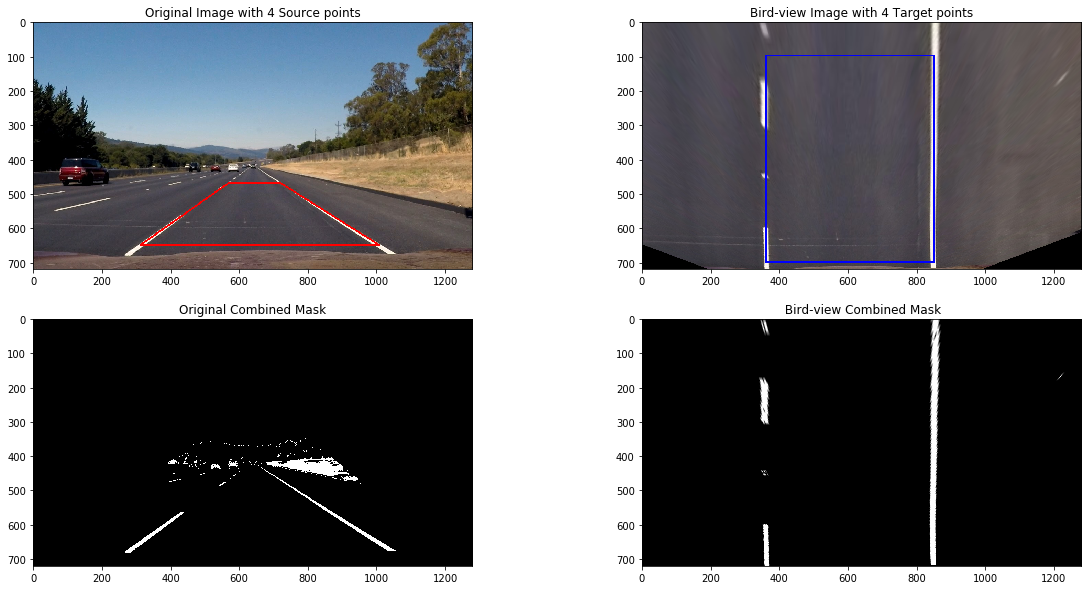

In [15]:
# define 4 points over a rectangular region within the lane in both the original view and the target (bird) view
points_orig = np.array([[312,650], [1007, 650], [720, 470], [568, 470]])
points_targ = np.array([[360,700], [850, 700], [850, 100], [360, 100]])

# make a copy of image for drawing
img_orig = np.copy(imgTest)
img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

# Compute the forward and reverse persepective transform matrices
M         = cv2.getPerspectiveTransform(np.float32(points_orig), np.float32(points_targ))
M_inv = cv2.getPerspectiveTransform(np.float32(points_targ), np.float32(points_orig))
sizImg = (img_orig.shape[1], img_orig.shape[0])

# Apply the forward transform to get bird view image
img_bird = cv2.warpPerspective(img_orig, M, sizImg , flags=cv2.INTER_LINEAR)

# Draw boundaries of the rectangular in both views
cv2.polylines(img_orig, np.int32([points_orig]), isClosed=True, color=[255,0,0], thickness=3)
cv2.polylines(img_bird, np.int32([points_targ]), isClosed=True, color=[0,0,255], thickness=3)

# get mask and the bird-view of it
mask = combinedMask
mask_bird = cv2.warpPerspective(np.float64(mask), M, sizImg, flags=cv2.INTER_LINEAR)

# Display
f, axhandles = plt.subplots(2,2, figsize=(20,10))

axhandles[0,0].imshow(img_orig)
axhandles[0,0].set_title('Original Image with 4 Source points')

axhandles[0,1].imshow(img_bird)
axhandles[0,1].set_title('Bird-view Image with 4 Target points')

axhandles[1,0].imshow(mask, cmap = 'gray')
axhandles[1,0].set_title('Original Combined Mask')

axhandles[1,1].imshow(mask_bird, cmap = 'gray')
axhandles[1,1].set_title(' Bird-view Combined Mask')

### Detect lane pixels and fit to find the lane boundary.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Initial Lane Centers: left = 357, right = 845
[ 2.31726588e-05 -8.25766631e-03  3.56370289e+02] [ 1.08760029e-05 -2.03226690e-02  8.54353756e+02]
Left curvature radius 15647.2 meter, Right curvature radius 33338.0 meter


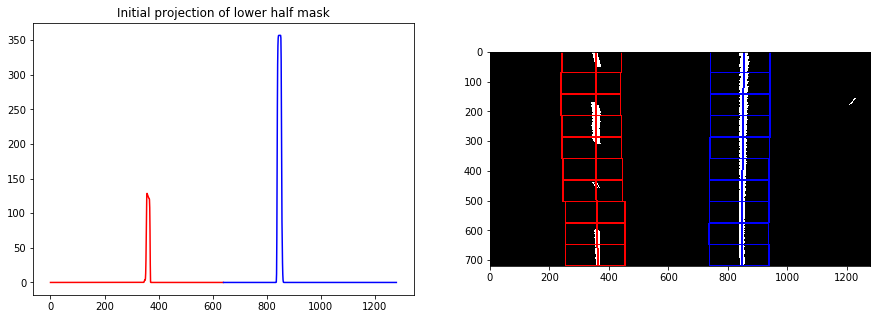

In [17]:
plt.rcParams['figure.figsize'] = (15, 5)

m = np.copy(mask_bird)
laneFinderObj = LaneFinder()
laneFinderObj.run(m)

proj = laneFinderObj.init_proj
halfLen = int(len(proj)/2)
rng1 = range(halfLen)
rng2 = range(halfLen, 2*halfLen)

plt.subplot(1,2,1)
plt.plot(rng1, proj[rng1], 'r', rng2, proj[rng2], 'b')
plt.title('Initial projection of lower half mask')

plt.subplot(1,2,2)
plt.imshow(laneFinderObj.out_img)
plt.show()

### Determine the curvature of the lane and vehicle position with respect to center.

In [7]:
print(np.where(mask_bird>0))

(array([  0,   0,   0, ..., 719, 719, 719]), array([341, 342, 343, ..., 367, 368, 369]))


### Warp the detected lane boundaries back onto the original image.

In [8]:
x = np.array([-1, -1, -1, 1,2,3,4,5,6,7,8,9,10])
y = np.where((x > 5) & (x < 9))
print(y)

(array([ 8,  9, 10]),)


### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.